# read TESS to ecsv file
<pre>
Reads TESS-W IDA-IAU file and adds Moon and Sun information
Creates an ecsv file
Jaime Zamorano (UCM)
v1.1 2023/06/11  + Sun altitude column 
</pre>

In [1]:
# Necessary packages

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime,timedelta

# Astropy
from astropy.time import Time
from astropy.table import QTable, Table, Column, vstack
from astropy.io import ascii
import astropy.units as u
import astropy.coordinates as ac
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astroplan import Observer

In [2]:
# just testing with one ecsv file
filename = 'stars1_2022-05.dat'

In [3]:
# creating the astropy Table
t = Table()

In [4]:
# reading data to Table
t = ascii.read(filename,delimiter=';',names=['date_UT','date_local', 'T_internal', 'T_Sky', 'Frequency', 'magnitude', 'ZP'])

In [5]:
t[0:5]

date_UT,date_local,T_internal,T_Sky,Frequency,magnitude,ZP
str23,str23,float64,float64,float64,float64,float64
2022-05-01T00:00:31.000,2022-05-01T02:00:31.000,18.5,4.1,43.95,15.99,20.1
2022-05-01T00:01:01.000,2022-05-01T02:01:01.000,18.5,4.0,38.8,16.13,20.1
2022-05-01T00:01:31.000,2022-05-01T02:01:31.000,18.5,3.9,33.04,16.3,20.1
2022-05-01T00:02:01.000,2022-05-01T02:02:01.000,18.5,3.9,30.16,16.4,20.1
2022-05-01T00:02:31.000,2022-05-01T02:02:31.000,18.5,3.8,27.87,16.49,20.1


In [6]:
# astropy.io  ascii reads header and stores as metadata
t.meta['comments']

['Definition of the community standard for skyglow observations 1.0',
 'URL: http://www.darksky.org/NSBM/sdf1.0.pdf',
 'Number of header lines: 35',
 'This data is released under the following license: ODbL 1.0 http://opendatacommons.org/licenses/odbl/summary/',
 'Device type: TESS-W',
 'Instrument ID: stars1',
 'Data supplier: Cristóbal García / AstroHenares',
 'Location name: Coslada/Madrid/Spain - Laboratorio de Cristóbal',
 'Position: 40.424604, -3.558091, 626.0',
 'Local timezone: Europe/Madrid',
 'Time Synchronization: timestamp added by MQTT subscriber',
 'Moving / Stationary position: STATIONARY',
 'Moving / Fixed look direction: FIXED',
 'Number of channels: 1',
 'Filters per channel: BG39',
 'Measurement direction per channel: 0.0, 0.0',
 'Field of view: 17.0',
 'Number of fields per line: 7',
 'TESS MAC address: 18:FE:34:CF:E9:5A',
 'TESS firmware version: 1.0',
 'TESS cover offset value: 0.0',
 'TESS zero point: 20.1',
 'Comment:',
 'Comment:',
 'Comment:',
 'Comment:',
 'C

In [7]:
# Information of name of data columns
t.meta['comments'][-3]

'UTC Date & Time, Local Date & Time, Enclosure Temperature, Sky Temperature, Frequency, MSAS, ZP'

In [8]:
# Information of name of photometer
t.meta['comments'][5]

'Instrument ID: stars1'

In [9]:
# Position information 
t.meta['comments'][8]

'Position: 40.424604, -3.558091, 626.0'

#### Extracting useful information from header

In [10]:
# Tengo que saltar las primeras lineas de comentarios en el header
# problemas al llegar a  'TESS MAC address: 98:F4:AB:B2:7B:BF'
# que tiene muchos ':' por eso paro en línea 18
# En el caso de stars1 Coslada paro en 15 porque
# 'Measurement direction per channel: 0.0, 0.0',  da fallo
header = ascii.read(t.meta['comments'][5:15], delimiter=':',
                    format='no_header', names=['key', 'val'])
print(header)

             key                                    val                      
----------------------------- -----------------------------------------------
                Instrument ID                                          stars1
                Data supplier                 Cristóbal García / AstroHenares
                Location name Coslada/Madrid/Spain - Laboratorio de Cristóbal
                     Position                     40.424604, -3.558091, 626.0
               Local timezone                                   Europe/Madrid
         Time Synchronization              timestamp added by MQTT subscriber
 Moving / Stationary position                                      STATIONARY
Moving / Fixed look direction                                           FIXED
           Number of channels                                               1
          Filters per channel                                            BG39


In [11]:
photometer = header[0]['val']
latitude   = header[3]['val'].split(',')[0] #* u.deg
longitude  = header[3]['val'].split(',')[1] #* u.deg
height     = header[3]['val'].split(',')[2] #* u.m
print('photometer:', photometer , '     coordinates:',latitude , longitude)

photometer: stars1      coordinates: 40.424604  -3.558091


#### Setting location for astronomical calculatios

In [12]:
location = ac.EarthLocation(lat=latitude,lon=longitude,height=height)
# Example of time in astropy Time system 
date_obs = t['date_UT'][100]
obs_time = Time(date_obs,scale='utc',location=location)  
print('datetime     :',date_obs)
print('astropy Time :',obs_time,obs_time.info)

datetime     : 2022-05-01T00:51:04.000
astropy Time : 2022-05-01T00:51:04.000 dtype = object
class = Time
n_bad = 0



In [13]:
# name of the observer site is not needed
observer = Observer(name='Coslada',location=location)

#### Ephemeris for Moon and Sun

In [14]:
# Example of calculation using location and time
moon_rise = observer.moon_rise_time(obs_time)
print('Moon rise JD:',moon_rise,'for ',obs_time)
# You can use Time or datetime as input
moon_rise = observer.moon_rise_time(date_obs)
moon_set  = observer.moon_set_time(date_obs)
print('Moon rise JD:',moon_rise,'for ',date_obs)
print('Moon rise   :',moon_rise.datetime,'for ',date_obs)
print('Moon set    :',moon_set.datetime,'for ',date_obs)

Moon rise JD: 2459700.7353903386 for  2022-05-01T00:51:04.000
Moon rise JD: 2459700.7353903386 for  2022-05-01T00:51:04.000
Moon rise   : 2022-05-01 05:38:57.725253 for  2022-05-01T00:51:04.000
Moon set    : 2022-04-30 18:52:27.509703 for  2022-05-01T00:51:04.000


In [15]:
# another method to convert to datetime
observer.astropy_time_to_datetime(moon_rise)

datetime.datetime(2022, 5, 1, 5, 38, 57, 725253, tzinfo=<UTC>)

In [16]:
# Moon position in the sky
print('Moon altitude',observer.moon_altaz(obs_time).alt)
print('Moon azimut  ',observer.moon_altaz(obs_time).az)
print('Moon phase   ',observer.moon_phase(obs_time) /(np.pi * u.rad))    # 0 new  1 full
print('Sun altitude ',observer.sun_altaz(obs_time).alt)
observer.sun_altaz(obs_time).alt

Moon altitude -35d04m19.0903s
Moon azimut   8d52m58.8462s
Moon phase    0.9873720898157644
Sun altitude  -33d47m56.5761s


<Latitude -33.79904891 deg>

In [17]:
t.info()

<Table length=37822>
   name     dtype 
---------- -------
   date_UT   str23
date_local   str23
T_internal float64
     T_Sky float64
 Frequency float64
 magnitude float64
        ZP float64


In [18]:
len(t)

37822

In [19]:
# new column with Julian Date
t['jd'] = Time(t['date_UT'],scale='utc',location=location).jd

In [20]:
# new column with object astropy Time 
t['Time'] = Time(t['date_UT'],scale='utc',location=location)

In [21]:
# new columns with Moon altitude and phase
t['moon_alt']   = observer.moon_altaz(t['Time']).alt.deg
t['moon_phase'] = observer.moon_phase(t['Time']) /(np.pi * u.rad)

In [22]:
# new column with Sun altitude 
t['sun_alt']   = observer.sun_altaz(t['Time']).alt.deg

In [23]:
t[0:5]

date_UT,date_local,T_internal,T_Sky,Frequency,magnitude,ZP,jd,Time,moon_alt,moon_phase,sun_alt
,,,,,,,,,,,
str23,str23,float64,float64,float64,float64,float64,float64,object,float64,float64,float64
2022-05-01T00:00:31.000,2022-05-01T02:00:31.000,18.5,4.1,43.95,15.99,20.1,2459700.500358796,2022-05-01T00:00:31.000,-35.51326315063141,0.9892756162259293,-34.51276139609294
2022-05-01T00:01:01.000,2022-05-01T02:01:01.000,18.5,4.0,38.8,16.13,20.1,2459700.5007060184,2022-05-01T00:01:01.000,-35.52027304901654,0.9892574092415708,-34.517832190262354
2022-05-01T00:01:31.000,2022-05-01T02:01:31.000,18.5,3.9,33.04,16.3,20.1,2459700.5010532406,2022-05-01T00:01:31.000,-35.52705624980562,0.9892391877068188,-34.52266012930278
2022-05-01T00:02:01.000,2022-05-01T02:02:01.000,18.5,3.9,30.16,16.4,20.1,2459700.501400463,2022-05-01T00:02:01.000,-35.53361266440513,0.9892209516871773,-34.527245147902065
2022-05-01T00:02:31.000,2022-05-01T02:02:31.000,18.5,3.8,27.87,16.49,20.1,2459700.501747685,2022-05-01T00:02:31.000,-35.53994220890166,0.9892027012663284,-34.53158718400306


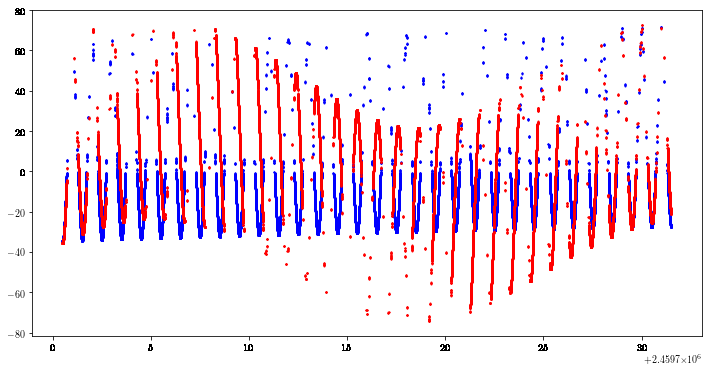

In [28]:
figura = plt.figure(figsize=(12, 6))
ax1=figura.add_subplot(111)

plt.plot(t['jd'],t['sun_alt'],'bo',ms=1)
plt.plot(t['jd'],t['moon_alt'],'ro',ms=1)

In [25]:
t[0:5]

date_UT,date_local,T_internal,T_Sky,Frequency,magnitude,ZP,jd,Time,moon_alt,moon_phase,sun_alt
,,,,,,,,,,,
str23,str23,float64,float64,float64,float64,float64,float64,object,float64,float64,float64
2022-05-01T00:00:31.000,2022-05-01T02:00:31.000,18.5,4.1,43.95,15.99,20.1,2459700.500358796,2022-05-01T00:00:31.000,-35.51326315063141,0.9892756162259293,-34.51276139609294
2022-05-01T00:01:01.000,2022-05-01T02:01:01.000,18.5,4.0,38.8,16.13,20.1,2459700.5007060184,2022-05-01T00:01:01.000,-35.52027304901654,0.9892574092415708,-34.517832190262354
2022-05-01T00:01:31.000,2022-05-01T02:01:31.000,18.5,3.9,33.04,16.3,20.1,2459700.5010532406,2022-05-01T00:01:31.000,-35.52705624980562,0.9892391877068188,-34.52266012930278
2022-05-01T00:02:01.000,2022-05-01T02:02:01.000,18.5,3.9,30.16,16.4,20.1,2459700.501400463,2022-05-01T00:02:01.000,-35.53361266440513,0.9892209516871773,-34.527245147902065
2022-05-01T00:02:31.000,2022-05-01T02:02:31.000,18.5,3.8,27.87,16.49,20.1,2459700.501747685,2022-05-01T00:02:31.000,-35.53994220890166,0.9892027012663284,-34.53158718400306


In [26]:
# writing Table to ecsv file
# New file with Moon information and new time columns
fileout  = filename.replace('dat','ecsv')
t.write(fileout, overwrite=True)  

In [27]:
print(fileout)

stars1_2022-05.ecsv
